### Download GTZAN from Kaggle

In [ ]:
!pip install kaggle

##### Create an API key from your Kaggle account as instructed here [How to Search and Download Data using Kaggle API?](https://towardsdatascience.com/how-to-search-and-download-data-using-kaggle-api-f815f7b98080)

In [ ]:
%mkdir ~/.kaggle/
%cp ./kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification
!rm -r gtzan-dataset-music-genre-classification.zip

100% 1.21G/1.21G [00:36<00:00, 66.1MB/s]

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating:

In [ ]:
import IPython.display as ipd
ipd.Audio('/content/Data/genres_original/country/country.00002.wav')

### Using LSTM with MFCCs

In [ ]:
import math
import json
import librosa
import os
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
def preprocess(dataset_path, num_mfcc=40, n_fft=2048, hop_length=512, num_segment=10):
  data = {"labels": [], "mfcc": []}
  sample_rate = 22050
  samples_per_segment = int(sample_rate*30/num_segment)
  
  for label_idx, (dirpath,dirnames,filenames) in enumerate(os.walk(dataset_path)):
    if dirpath == dataset_path:
      continue

    for f in sorted(filenames):
      if not f.endswith('.wav'):
        continue
      file_path = str(str(dirpath).split('\\')[-1]) + "/" + str(f)
      print("Track Name ", file_path)
      
      try:
        y, sr = librosa.load(file_path, sr = sample_rate)
      except:
        continue
      for n in range(num_segment):
        mfcc = librosa.feature.mfcc(y[samples_per_segment*n: samples_per_segment*(n+1)], 
                                    sample_rate, n_mfcc = num_mfcc, n_fft = n_fft, 
                                    hop_length = hop_length)
        mfcc = mfcc.T
        if len(mfcc) == math.ceil(samples_per_segment / hop_length):
          data["mfcc"].append(mfcc.tolist())
          data["labels"].append(label_idx-1)
  return data

In [ ]:
%%time
mfcc_data = preprocess('./Data/genres_original')

Track Name  ./Data/genres_original/country/country.00000.wav
Track Name  ./Data/genres_original/country/country.00001.wav
Track Name  ./Data/genres_original/country/country.00002.wav
Track Name  ./Data/genres_original/country/country.00003.wav
Track Name  ./Data/genres_original/country/country.00004.wav
Track Name  ./Data/genres_original/country/country.00005.wav
Track Name  ./Data/genres_original/country/country.00006.wav
Track Name  ./Data/genres_original/country/country.00007.wav
Track Name  ./Data/genres_original/country/country.00008.wav
Track Name  ./Data/genres_original/country/country.00009.wav
Track Name  ./Data/genres_original/country/country.00010.wav
Track Name  ./Data/genres_original/country/country.00011.wav
Track Name  ./Data/genres_original/country/country.00012.wav
Track Name  ./Data/genres_original/country/country.00013.wav
Track Name  ./Data/genres_original/country/country.00014.wav
Track Name  ./Data/genres_original/country/country.00015.wav
Track Name  ./Data/genre

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Track Name  ./Data/genres_original/jazz/jazz.00055.wav
Track Name  ./Data/genres_original/jazz/jazz.00056.wav
Track Name  ./Data/genres_original/jazz/jazz.00057.wav
Track Name  ./Data/genres_original/jazz/jazz.00058.wav
Track Name  ./Data/genres_original/jazz/jazz.00059.wav
Track Name  ./Data/genres_original/jazz/jazz.00060.wav
Track Name  ./Data/genres_original/jazz/jazz.00061.wav
Track Name  ./Data/genres_original/jazz/jazz.00062.wav
Track Name  ./Data/genres_original/jazz/jazz.00063.wav
Track Name  ./Data/genres_original/jazz/jazz.00064.wav
Track Name  ./Data/genres_original/jazz/jazz.00065.wav
Track Name  ./Data/genres_original/jazz/jazz.00066.wav
Track Name  ./Data/genres_original/jazz/jazz.00067.wav
Track Name  ./Data/genres_original/jazz/jazz.00068.wav
Track Name  ./Data/genres_original/jazz/jazz.00069.wav
Track Name  ./Data/genres_original/jazz/jazz.00070.wav
Track Name  ./Data/genres_original/jazz/jazz.00071.wav
Track Name  ./Data/genres_original/jazz/jazz.00072.wav
Track Name

In [ ]:
x = np.array(mfcc_data["mfcc"])
y = np.array(mfcc_data["labels"])

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.2)

input_shape = (x_train.shape[1],x_train.shape[2])


y_train[y_train==10] = 9
y_val[y_val==10] = 9
y_test[y_test==10] = 9

input_shape = (x_train.shape[1],x_train.shape[2])

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape = input_shape, return_sequences = True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(10,activation = "softmax"))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=60, verbose=2)
model.save("GTZAN_LSTM.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


188/188 - 30s - loss: 1.6897 - accuracy: 0.3976 - val_loss: 1.4831 - val_accuracy: 0.4346 - 30s/epoch - 157ms/step
Epoch 2/50
188/188 - 25s - loss: 1.3851 - accuracy: 0.4972 - val_loss: 1.4621 - val_accuracy: 0.4700 - 25s/epoch - 132ms/step
Epoch 3/50
188/188 - 25s - loss: 1.2885 - accuracy: 0.5311 - val_loss: 1.2504 - val_accuracy: 0.5487 - 25s/epoch - 135ms/step
Epoch 4/50
188/188 - 25s - loss: 1.2021 - accuracy: 0.5633 - val_loss: 1.2092 - val_accuracy: 0.5554 - 25s/epoch - 131ms/step
Epoch 5/50
188/188 - 24s - loss: 1.1625 - accuracy: 0.5767 - val_loss: 1.1743 - val_accuracy: 0.5688 - 24s/epoch - 127ms/step
Epoch 6/50
188/188 - 24s - loss: 1.0649 - accuracy: 0.6179 - val_loss: 1.1165 - val_accuracy: 0.5901 - 24s/epoch - 130ms/step
Epoch 7/50
188/188 - 24s - loss: 1.0104 - accuracy: 0.6393 - val_loss: 1.0860 - val_accuracy: 0.6015 - 24s/epoch - 130ms/step
Epoch 8/50
188/188 - 24s - loss: 0.9531 - accuracy: 0.6580 - val_loss: 1.1149 - val_accuracy: 0.5955 - 24s/epoch - 127ms/step
Epo

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
np.sum(y_pred==y_test)/len(y_pred)

0.803764517420905

### Using all extra given features

In [ ]:
import pandas as pd

gtzan_data = pd.read_csv('/content/Data/features_3_sec.csv')
gtzan_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
X = gtzan_data.iloc[:,1:-1]
y = gtzan_data.label

X_np = X.to_numpy()
print(X_np.shape)
X_ts = []
y_ts = []
window_size = 50

for i in range(X_np.shape[0]-window_size):
  X_ts.append(X_np[i: window_size + i,:].tolist())
  y_ts.append(y[i])
  
X_ts_np = np.array(X_ts, dtype=object).astype('float32')
y_ts_np = np.array(y_ts, dtype=object)

print(X_ts_np.shape)
print(y_ts_np.shape)

(9990, 58)
(9940, 50, 58)
(9940,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_ts_np = label_encoder.fit_transform(y_ts_np)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ts_np, y_ts_np, test_size=0.2, 
                                                    stratify=y_ts_np, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                    stratify=y_train, random_state=42)

In [ ]:
import tensorflow as tf

input_shape = X_train.shape[1:]
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape = input_shape))
model2.add(tf.keras.layers.LSTM(64))
model2.add(tf.keras.layers.Dense(64, activation="relu"))
model2.add(tf.keras.layers.Dense(10,activation = "softmax"))

optimiser = tf.keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50, 64)            31488     
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 69,322
Trainable params: 69,322
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=60, verbose=2)
model2.save("GTZAN_full_LSTM.h5")

Epoch 1/50
199/199 - 15s - loss: 1.8683 - accuracy: 0.3066 - val_loss: 1.8968 - val_accuracy: 0.2766 - 15s/epoch - 76ms/step
Epoch 2/50
199/199 - 11s - loss: 1.5714 - accuracy: 0.4084 - val_loss: 1.5253 - val_accuracy: 0.4381 - 11s/epoch - 54ms/step
Epoch 3/50
199/199 - 11s - loss: 1.4943 - accuracy: 0.4345 - val_loss: 1.4012 - val_accuracy: 0.4745 - 11s/epoch - 54ms/step
Epoch 4/50
199/199 - 16s - loss: 1.3705 - accuracy: 0.4716 - val_loss: 1.2695 - val_accuracy: 0.5167 - 16s/epoch - 79ms/step
Epoch 5/50
199/199 - 12s - loss: 1.3335 - accuracy: 0.4774 - val_loss: 1.2111 - val_accuracy: 0.5185 - 12s/epoch - 60ms/step
Epoch 6/50
199/199 - 11s - loss: 1.3666 - accuracy: 0.4575 - val_loss: 1.3398 - val_accuracy: 0.5003 - 11s/epoch - 53ms/step
Epoch 7/50
199/199 - 11s - loss: 1.2639 - accuracy: 0.5081 - val_loss: 1.2358 - val_accuracy: 0.5173 - 11s/epoch - 53ms/step
Epoch 8/50
199/199 - 11s - loss: 1.2188 - accuracy: 0.5249 - val_loss: 1.1734 - val_accuracy: 0.5405 - 11s/epoch - 53ms/step


In [ ]:
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
np.sum(y_pred==y_test)/len(y_pred)

0.778169014084507



```
# This is formatted as code
```

### With CNN using MFCCs

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

In [ ]:
x = np.array(mfcc_data["mfcc"])
y = np.array(mfcc_data["labels"])

x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = tf.keras.utils.to_categorical(y, num_classes=10)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.2)

y_train[y_train==10] = 9
y_val[y_val==10] = 9
y_test[y_test==10] = 9

input_shape = x_train.shape[1:]

In [ ]:
print(x_train.shape, y_train.shape)

(5991, 130, 40, 1) (5991, 10)


In [ ]:
input_shape = x_train.shape[1:]

cnn_model =  models.Sequential([
                    layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', 
                                  input_shape = input_shape),  
                    layers.MaxPooling2D(2, padding='same'),

                    layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                    layers.MaxPooling2D(2, padding='same'),
                    layers.Dropout(0.3),

                    layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                    layers.MaxPooling2D(2, padding='same'),
                    layers.Dropout(0.3),

                    layers.GlobalAveragePooling2D(),
                    layers.Dense(512 , activation = 'relu'),
                    layers.Dense(10 , activation = 'softmax')
])

cnn_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'acc')
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 38, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 17, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 9, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 9, 128)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 7, 128)        1

In [ ]:
history = cnn_model.fit(x_train, y_train,
                    validation_data=(x_val,y_val),
                    epochs=40,
                    verbose = 2,
                    batch_size=32)

Epoch 1/40
188/188 - 16s - loss: 0.2620 - acc: 0.3789 - val_loss: 0.2200 - val_acc: 0.4553 - 16s/epoch - 84ms/step
Epoch 2/40
188/188 - 4s - loss: 0.2018 - acc: 0.5321 - val_loss: 0.1957 - val_acc: 0.5507 - 4s/epoch - 19ms/step
Epoch 3/40
188/188 - 4s - loss: 0.1782 - acc: 0.6089 - val_loss: 0.1646 - val_acc: 0.6475 - 4s/epoch - 19ms/step
Epoch 4/40
188/188 - 4s - loss: 0.1627 - acc: 0.6435 - val_loss: 0.1607 - val_acc: 0.6595 - 4s/epoch - 20ms/step
Epoch 5/40
188/188 - 4s - loss: 0.1484 - acc: 0.6832 - val_loss: 0.1410 - val_acc: 0.7043 - 4s/epoch - 20ms/step
Epoch 6/40
188/188 - 4s - loss: 0.1325 - acc: 0.7249 - val_loss: 0.1354 - val_acc: 0.7210 - 4s/epoch - 20ms/step
Epoch 7/40
188/188 - 4s - loss: 0.1261 - acc: 0.7460 - val_loss: 0.1335 - val_acc: 0.7296 - 4s/epoch - 19ms/step
Epoch 8/40
188/188 - 4s - loss: 0.1145 - acc: 0.7660 - val_loss: 0.1271 - val_acc: 0.7450 - 4s/epoch - 19ms/step
Epoch 9/40
188/188 - 4s - loss: 0.1066 - acc: 0.7855 - val_loss: 0.1061 - val_acc: 0.7844 - 4s

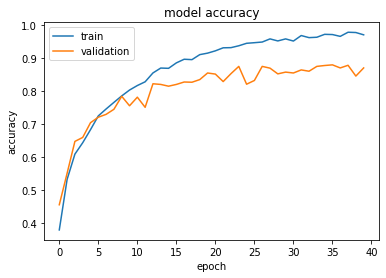

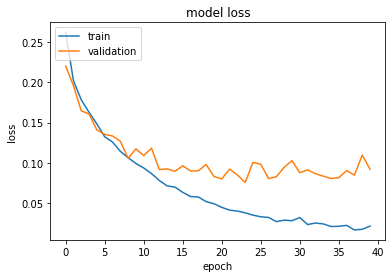

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(np.sum(y_pred==y_test)/len(y_pred))

0.8858630356427714


### With CNN using Mel Spectrograms

In [ ]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

im = cv2.imread('/content/Data/images_original/blues/blues00000.png')
input_shape = im.shape
print(input_shape)

(288, 432, 3)


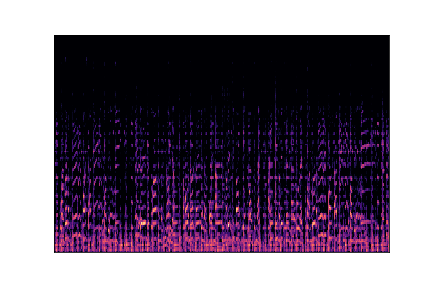

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(im)

In [ ]:
def load_image_data(img_folder):
  X = []
  y = []

  for genre_folder in os.listdir(img_folder):
    X = X + [cv2.imread(os.path.join(img_folder, genre_folder, curr_file)) 
              for curr_file in os.listdir(os.path.join(img_folder, genre_folder))]
    y = y + [genre_folder]*len(os.listdir(os.path.join(img_folder, genre_folder)))
  
  return np.array(X), np.array(y)

In [ ]:
%%time
X_img, y_img = load_image_data('/content/Data/images_original')

CPU times: user 2.99 s, sys: 1.27 s, total: 4.27 s
Wall time: 5.15 s


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_img = label_encoder.fit_transform(y_img)

x_train, x_test, y_train, y_test = train_test_split(X_img, y_img, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

image_model = None
image_model = Sequential()
image_model.add(Conv2D(128,3,padding="same", activation="relu", input_shape=input_shape))
image_model.add(MaxPool2D())

image_model.add(Conv2D(64, 3, padding="same", activation="relu"))
image_model.add(MaxPool2D())

image_model.add(Conv2D(32, 3, padding="same", activation="relu"))
image_model.add(MaxPool2D())

image_model.add(Conv2D(32, 3, padding="same", activation="relu"))
image_model.add(MaxPool2D())
image_model.add(Dropout(0.2))

image_model.add(Flatten())
image_model.add(Dense(128,activation="relu"))
image_model.add(Dense(10, activation="softmax"))

image_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 288, 432, 128)     3584      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 144, 216, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 144, 216, 64)      73792     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 72, 108, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 72, 108, 32)       18464     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 36, 54, 32)      

In [ ]:
opt = Adam(lr=0.0001)
image_model.compile(optimizer = opt,
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'])

In [ ]:
history = image_model.fit(x_train,y_train,
                          epochs = 100, 
                          validation_data = (x_val, y_val),
                          batch_size=32,
                          verbose=2)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 - 19s - loss: 16.7238 - accuracy: 0.1095 - val_loss: 4.1753 - val_accuracy: 0.1125 - 19s/epoch - 962ms/step
Epoch 2/100
20/20 - 11s - loss: 3.1339 - accuracy: 0.1487 - val_loss: 2.2036 - val_accuracy: 0.1688 - 11s/epoch - 566ms/step
Epoch 3/100
20/20 - 12s - loss: 2.2639 - accuracy: 0.2269 - val_loss: 1.9438 - val_accuracy: 0.2625 - 12s/epoch - 576ms/step
Epoch 4/100
20/20 - 11s - loss: 2.0408 - accuracy: 0.2660 - val_loss: 1.8200 - val_accuracy: 0.3000 - 11s/epoch - 565ms/step
Epoch 5/100
20/20 - 12s - loss: 1.8457 - accuracy: 0.3286 - val_loss: 1.7338 - val_accuracy: 0.3375 - 12s/epoch - 575ms/step
Epoch 6/100
20/20 - 11s - loss: 1.7155 - accuracy: 0.3881 - val_loss: 1.6039 - val_accuracy: 0.3625 - 11s/epoch - 575ms/step
Epoch 7/100
20/20 - 11s - loss: 1.5508 - accuracy: 0.4460 - val_loss: 1.5856 - val_accuracy: 0.4062 - 11s/epoch - 566ms/step
Epoch 8/100
20/20 - 11s - loss: 1.4443 - accuracy: 0.4992 - val_loss: 1.4927 - val_accuracy: 0.4125 - 11s/epoch - 566ms/step
Epoch 9/100

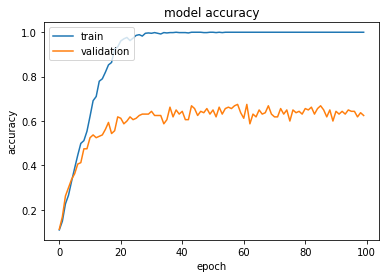

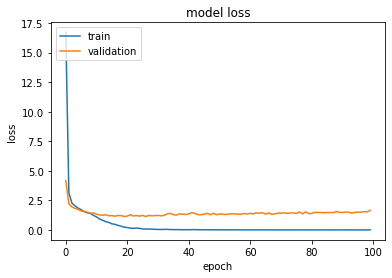

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = image_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(np.sum(y_pred==y_test)/len(y_pred))

0.655
